# Regresión de datos MPG usando redes neuronales

Este notebook se recomienda ejecutarse en Google Colab.

Antes de compilar los bloques se debe cargar los datos procesados de la carpeta [`datasets/mpg`](https://github.com/RicardxJMG/deep-learning-diplomado/blob/main/datasets/mpg) del repositorioy guardarlos en una carpeta llamada *data*. 

También se debe de crear la carpeta *src* en el cual se deben incluir los scripts [`load_from_zip.py`](https://github.com/RicardxJMG/deep-learning-diplomado/blob/main/Tareas/src/load_from_zip.py) y [`regression_desing.py`](https://github.com/RicardxJMG/deep-learning-diplomado/blob/main/Tareas/src/regression_desing.py) 

## 1. Importando librerías y cargando datos procesados

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
# from sklearn.model_selection import train_test_split
# script adicionales

from src.regression_desing import disenar_red_regresion
from src.load_from_zip import load_processed_data_from_zip
# sustituir si se manda a local el archivo

warnings.filterwarnings('ignore')


SEED = 7


np.random.seed(SEED)
tf.random.set_seed(SEED)


datapath = Path().resolve() / 'data'
zip_path = datapath / 'mpg_procesado.zip'




In [ ]:
train_loaded, val_loaded, test_loaded, _, metadata = load_processed_data_from_zip(zip_path)

Datos extraidos correctamente


In [30]:
X_train = train_loaded.drop(columns = ["target"])
y_train = train_loaded["target"]

X_val = val_loaded.drop(columns = ["target"])
y_val = val_loaded["target"]

X_test = test_loaded.drop(columns= ["target"])
y_test = test_loaded["target"]

print("X_train.shape = ", X_train.shape)
print("X_val.shape = ", X_val.shape)
print("X_test.shape = ", X_test.shape)

X_train.shape =  (251, 9)
X_val.shape =  (63, 9)
X_test.shape =  (79, 9)


> Los datos están listos para entrenar el modelo

## 2. Entrenamiento

In [ ]:
def build_regression_mlp(n0: int, capas: list, l2_value: float, dropouts: list, seed: int = SEED) -> keras.Model:
    assert len(capas) == len(dropouts), "capas y dropouts deben tener la misma longitud"

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n0,)))

    initializer = tf.keras.initializers.GlorotUniform(seed=seed)

    for units, dr in zip(capas, dropouts):
        model.add(
            keras.layers.Dense(
                units,
                activation="relu",
                kernel_initializer=initializer,
                kernel_regularizer=keras.regularizers.l2(l2_value)
            )
        )
        model.add(keras.layers.Dropout(dr, seed=seed))

    # salida lineal
    model.add(keras.layers.Dense(1,
                        kernel_initializer = initializer,
                        activation="linear"))

    #
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.MeanSquaredError(name="mse"),
        keras.metrics.RootMeanSquaredError(name="rmse"),])

    return model

In [32]:
d  = X_train.shape[0]   # tamaño del entrenamiento
n0 = X_train.shape[1]   # número de variables de entrada

print("d =", d)
print("n0 =", n0)


d = 251
n0 = 9


In [33]:
diseno = disenar_red_regresion(d,n0)
print(diseno)

DisenoRedRegresion(capas=[18, 9], P=361, rho=0.14382470119521912, l2=0.0003, dropouts=[0.24999999999999997, 0.21249999999999997], patience=20, min_delta=0.0001, max_epochs=400)


In [34]:
capas     = diseno.capas
l2_value  = diseno.l2
dropouts  = diseno.dropouts
patience  = diseno.patience
min_delta = diseno.min_delta
max_epochs= diseno.max_epochs


model = build_regression_mlp(n0=n0, capas=capas, l2_value=l2_value, dropouts=dropouts)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 18)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           171 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Entrenar + validar (Early Stoping)


In [35]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=1
    )
]

BATCH_SIZE = 32

history = model.fit(
    X_train.astype(np.float32),
    y_train.values,
    validation_data=(X_val.astype(np.float32), y_val.values),
    epochs=max_epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 580.6452 - mae: 22.8491 - mse: 580.6375 - rmse: 24.0953 - val_loss: 595.1517 - val_mae: 22.9878 - val_mse: 595.1440 - val_rmse: 24.3956
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 576.6293 - mae: 22.7551 - mse: 576.6215 - rmse: 24.0119 - val_loss: 589.0931 - val_mae: 22.8477 - val_mse: 589.0853 - val_rmse: 24.2711
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 567.0065 - mae: 22.5263 - mse: 566.9988 - rmse: 23.8105 - val_loss: 582.6749 - val_mae: 22.6989 - val_mse: 582.6671 - val_rmse: 24.1385
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 561.5827 - mae: 22.3894 - mse: 561.5749 - rmse: 23.6965 - val_loss: 575.7719 - val_mae: 22.5380 - val_mse: 575.7639 - val_rmse: 23.9951
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 552.9817 - mae: 22.1490 - mse: 552.9738 - rmse: 23.5142 - val_loss: 568.2474 - val_mae: 22.3604 - val_mse: 568.2394 - val_rmse: 23.8378
Epoch 6/400
8/8 ━━━━━━━━━━━━━━━━

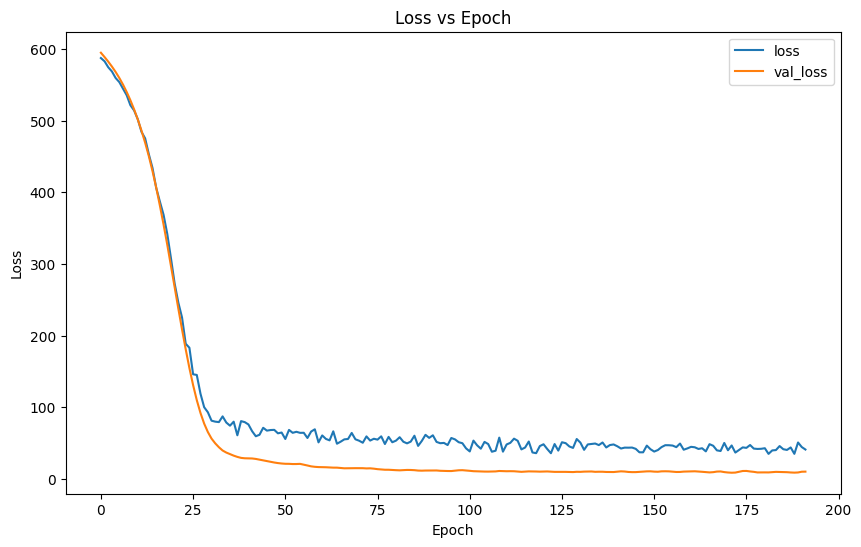

In [36]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

figure = plt.figure(figsize=(10, 6))
ax = plt.gca()
history_df.plot(y=["loss", "val_loss"], ax=ax)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epoch")

plt.show()


> No hay mejora significativa a partir de la época 172 (usando la cpu)

## 4. Evaluando en test

In [37]:
test_metrics = model.evaluate(
    X_test.astype(np.float32),
    y_test.values,
    verbose=0,
    return_dict=True
)
print("Métricas en test:", test_metrics)

Métricas en test: {'loss': 11.036321640014648, 'mae': 2.535426616668701, 'mse': 11.022405624389648, 'rmse': 3.3200008869171143}


## 5. Guardando el modelo

In [38]:
import json
import zipfile
import pandas as pd

# ===========================
# 1) Rutas de salida
# ===========================
OUT_DIR = "salida_regresion"
ZIP_NAME = "resultados.zip"

os.makedirs(OUT_DIR, exist_ok=True)

# ===========================
# 2) Guardar metadatos del experimento
# ===========================
metadata = {
    "n_samples_train": int(d),
    "n_features": int(n0),
    "architecture": capas,
    "l2": float(l2_value),
    "dropouts": dropouts,
    "patience": patience,
    "min_delta": min_delta,
    "max_epochs": max_epochs,
    "metrics_test": test_metrics,
}

with open(os.path.join(OUT_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

# ===========================
# 3) Guardar modelo (ya entrenado)
# ===========================
model_path = os.path.join(OUT_DIR, "modelo.keras")
model.save(model_path)

# ===========================
# 4) Guardar historial de entrenamiento
# ===========================
history_path = os.path.join(OUT_DIR, "historial_entrenamiento.csv")
pd.DataFrame(history.history).to_csv(history_path, index=False)

# ===========================
# 5) Empaquetar todo en ZIP
# ===========================
with zipfile.ZipFile(ZIP_NAME, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in [model_path, history_path, os.path.join(OUT_DIR, "metadata.json")]:
        zipf.write(file, arcname=os.path.basename(file))

print(f"ZIP generado correctamente: {ZIP_NAME}")


ZIP generado correctamente: resultados.zip


## 6. Predicciones con los datos nuevos

In [39]:
mpg_nuevos = pd.read_csv(datapath / "mpg_nuevos_procesados.csv")
mpg_true  = np.array([27, 44, 32, 28, 31])
mpg_nuevos

,displacement,horsepower,weight,acceleration,model_year,cylinders,origin___europe,origin___japan,origin___usa
0,-0.544448,-0.494002,-0.241085,0.046655,1.688589,-0.894578,0.0,0.0,1.0
1,-0.949662,-1.382476,-1.009157,3.221176,1.688589,-0.894578,1.0,0.0,0.0
2,-0.591566,-0.546265,-0.817139,-1.364243,1.688589,-0.894578,0.0,0.0,1.0
3,-0.732920,-0.676923,-0.433103,1.104829,1.688589,-0.894578,0.0,0.0,1.0
4,-0.742343,-0.598528,-0.322548,1.387008,1.688589,-0.894578,0.0,0.0,1.0


In [40]:
mpg_nuevos_pred = model.predict(mpg_nuevos)
mpg_nuevos_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[28.312128],
       [35.732376],
       [32.807266],
       [29.795216],
       [29.085857]], dtype=float32)

In [41]:
mpg_comparacion = pd.DataFrame({
    "mpg real": mpg_true,
    "mpg predicción": mpg_nuevos_pred.flatten(),
    "diferencia abs": np.abs(mpg_true - mpg_nuevos_pred.flatten())
})
mpg_comparacion

,mpg real,mpg predicción,diferencia abs
0,27,28.312128,1.312128
1,44,35.732376,8.267624
2,32,32.807266,0.807266
3,28,29.795216,1.795216
4,31,29.085857,1.914143
